<a href="https://colab.research.google.com/github/cxbxmxcx/GenReality/blob/master/GEN_5_UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title INSTALLS
!pip install livelossplot --quiet

In [ ]:
#@title IMPORTS
from torch.utils.data.dataset import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import train_test_split

import os
import numpy as np
import math
import itertools
import scipy
import sys
import time
import datetime

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
import torch.autograd as autograd
from torchvision.utils import make_grid

import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.nn.init as init

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from livelossplot import PlotLosses

In [ ]:
#@title HYPERPARAMETERS 
class Hyperparameters(object):
  def __init__(self, **kwargs):
    self.__dict__.update(kwargs)

hp = Hyperparameters(
    epoch=0,
    n_epochs=5,
    batch_size=32,    
    dataset_name="piscisRecognition",
    dataset_url="https://www.dropbox.com/s/i085djwcbb8xwop/piscisRecognition.zip?dl=1",       
    lr=.0002,
    decay_epoch=100,
    b1=.5,
    b2=0.999,
    n_cpu=8,
    img_size=128,
    channels=3,
    test_size=.2,
    sample_interval=100)

img_root_folder = 'images'
os.makedirs(img_root_folder, exist_ok=True)
image_folder = img_root_folder + "/%s" % hp.dataset_name 
print(f"Image data folders constructed {image_folder}")
os.makedirs(image_folder, exist_ok=True)

Image data folders constructed images/piscisRecognition


In [ ]:
#@title DOWNLOAD DATASET
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile
zipurl = hp.dataset_url
with urlopen(zipurl) as zipresp:
    with ZipFile(BytesIO(zipresp.read())) as zfile:        
        zfile.extractall(image_folder)
        print(f"Downloaded & Extracted {zipurl}")

Downloaded & Extracted https://www.dropbox.com/s/i085djwcbb8xwop/piscisRecognition.zip?dl=1


In [ ]:
#@title IMAGE DOWNLOAD HELPERS AND FORMATTERS
import random
import re
from PIL import Image
from glob import glob

class FishDataset(Dataset):
    def __init__(self, root_dir, transform=None, target_transform=None):        
        self.root_dir = os.path.abspath(root_dir)
        self.transform = transform
        self.target_transform = target_transform
       
        if not self._check_exists():
            raise RuntimeError('Dataset not found.')

        self.images = glob(os.path.join(root_dir, 'fish_image/*/*.png'))
        self.masks = [re.sub('fish', 'mask', image) for image in self.images]
        print(self.masks[0])
        self.labels = [int(re.search('.*fish_image/fish_(\d+)', image).group(1)) for image in self.images]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        label = self.labels[index]
        image = Image.open(self.images[index])
        mask = Image.open(self.masks[index])

        if mask.mode == '1':
            mask = mask.convert('L')

        # https://github.com/pytorch/vision/issues/9
        seed = np.random.randint(2147483647)
        random.seed(seed)
        if self.transform is not None:
            image = self.transform(image)

        random.seed(seed)
        if self.target_transform is not None:
            mask = self.target_transform(mask)
            mask = mask.round()

        return (image, mask, label)

    def _check_exists(self):
        return os.path.exists(os.path.join(self.root_dir, 'fish_image')) and \
               os.path.exists(os.path.join(self.root_dir, 'mask_image'))


In [ ]:
#@title CONFIGURE DATALOADERS
train_transform = transforms.Compose([
    transforms.Resize(size=(hp.img_size, hp.img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(hp.img_size, hp.img_size)),
    transforms.ToTensor()
])

train_dataset = FishDataset(image_folder, transform=train_transform,
                target_transform=train_transform)
train_indices, test_indices = train_test_split(np.arange(len(train_dataset)),
                                              test_size=hp.test_size, random_state=42)

train_loader = DataLoader(
    train_dataset,
    batch_size=hp.batch_size,
    sampler=SubsetRandomSampler(train_indices),
    num_workers=hp.n_cpu
)

val_loader = DataLoader(
    FishDataset(image_folder, transform=test_transform,
                target_transform=test_transform),
                batch_size=hp.batch_size,
                sampler=SubsetRandomSampler(train_indices),
                num_workers=hp.n_cpu
)

images/piscisRecognition/mask_image/mask_04/mask_000017100001_01536.png
images/piscisRecognition/mask_image/mask_04/mask_000017100001_01536.png


In [ ]:
#@title IMAGE VISUALIZER HELPERS
def imshow(img,size=10):
  img = img / 2 + 0.5     
  npimg = img.numpy()
  plt.figure(figsize=(size, size))
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

def to_img(x):    
    x = x.view(x.size(0)*2, hp.channels, hp.img_size, hp.img_size)
    return x

import matplotlib.image as mpimg
def visualise_output(path, x, y):
    img = mpimg.imread(path)
    plt.figure(figsize=(x,y))
    plt.imshow(img)  
    plt.show()

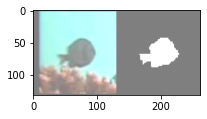

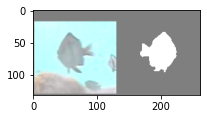

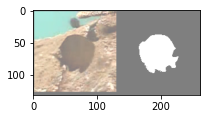

In [ ]:
#@title VISUALING SAMPLE DATA { run: "auto" }
pic_size = 3 #@param {type:"integer"} {type:"slider", min:1, max:30, step:1}
no_images = 3 #@param {type:"integer"} {type:"slider", min:1, max:32, step:1}

dataiter = iter(train_loader)
(images, masks, _) = dataiter.next()
img_sample, mask_sample = zip(*random.sample(list(zip(images, masks)), no_images))
for i in range(len(img_sample)):  
  imshow(make_grid([img_sample[i], mask_sample[i].repeat(3, 1, 1)]), size=pic_size)

In [ ]:
#@title JACCARD FUNCTION
def jaccard(outputs, targets):
    outputs = outputs.view(outputs.size(0), -1)
    targets = targets.view(targets.size(0), -1)
    intersection = (outputs * targets).sum(1)
    union = (outputs + targets).sum(1) - intersection
    jac = (intersection + 0.001) / (union + 0.001)
    return jac.mean()

In [ ]:
#@title UNET

class Upsample(nn.Module):
    """ nn.Upsample is deprecated """
    def __init__(self, scale_factor, mode="nearest"):
        super(Upsample, self).__init__()
        self.scale_factor = scale_factor
        self.mode = mode

    def forward(self, x):
        x = F.interpolate(x, scale_factor=self.scale_factor, mode=self.mode)
        return x

class ConvBlock(nn.Module):
    def __init__(self, in_channels,  out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        init.xavier_uniform(self.conv.weight, gain=np.sqrt(2))
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.leaky_relu = nn.LeakyReLU(0.01)

    def forward(self, x):
        x = self.conv(x)
        x = self.batch_norm(x)
        x = self.leaky_relu(x)
        return x

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.down1 = nn.Sequential(
            ConvBlock(3, 32),
            ConvBlock(32, 32)
        )
        self.down2 = nn.Sequential(
            ConvBlock(32, 64),
            ConvBlock(64, 64)
        )
        self.down3 = nn.Sequential(
            ConvBlock(64, 128),
            ConvBlock(128, 128)
        )

        self.middle = ConvBlock(128, 128)

        self.up3 = nn.Sequential(
            ConvBlock(256, 256),
            ConvBlock(256, 64)
        )

        self.up2 = nn.Sequential(
            ConvBlock(128, 128),
            ConvBlock(128, 32)
        )

        self.up1 = nn.Sequential(
            ConvBlock(64, 64),
            ConvBlock(64, 1)
        )

    def forward(self,  x):
        down1 = self.down1(x)
        out = F.max_pool2d(down1, 2)

        down2 = self.down2(out)
        out = F.max_pool2d(down2, 2)

        down3 = self.down3(out)
        out = F.max_pool2d(down3, 2)

        out = self.middle(out)

        out = Upsample(scale_factor=2)(out) 
        out = torch.cat([down3, out], 1)
        out = self.up3(out)

        out = Upsample(scale_factor=2)(out)
        out = torch.cat([down2, out], 1)
        out = self.up2(out)

        out = Upsample(scale_factor=2)(out)
        out = torch.cat([down1, out], 1)
        out = self.up1(out)

        out = torch.sigmoid(out)

        return out

In [ ]:
#@title CREATE THE LOSS AND MODELS
cuda = True if torch.cuda.is_available() else False
print("Using CUDA" if cuda else "Not using CUDA")

loss_fn = nn.BCELoss()

model = UNet()
if cuda:
  model.cuda()
  loss_fn.cuda()



Using CUDA


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


In [ ]:
#@title OPTIMIZERS
optimizer = torch.optim.Adam(model.parameters(), lr=hp.lr, betas=(hp.b1, hp.b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [ ]:
#@title SAMPLING IMAGES
def sample_images(batches_done):
    """Saves a generated sample from the validation set"""
    imgs, masks, _ = next(iter(val_loader))
    images = Variable(imgs.type(Tensor))    
    masks = model(images)
    masks = masks.repeat(1, 3, 1, 1)
    print(images.shape, masks.shape)
    img_sample = torch.cat((images.data, masks.data), -1)
    path = "images/%s.png" % (batches_done)
    save_image(img_sample, path, nrow=8, normalize=True) 
    return path

import matplotlib.image as mpimg
def visualise_output(path, x, y):
    img = mpimg.imread(path)
    plt.figure(figsize=(x,y))
    plt.imshow(img)  
    plt.show()

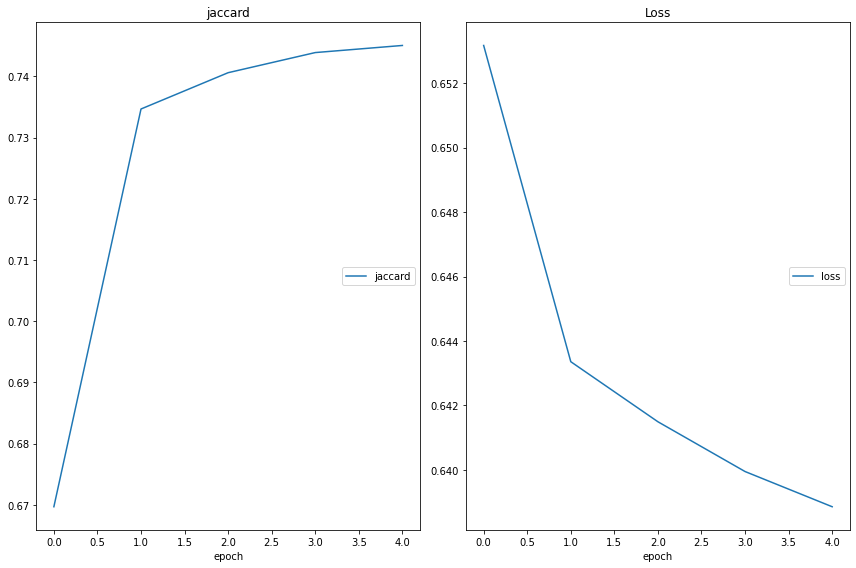

jaccard
	jaccard          	 (min:    0.670, max:    0.745, cur:    0.745)
Loss
	loss             	 (min:    0.639, max:    0.653, cur:    0.639)
torch.Size([32, 3, 128, 128]) torch.Size([32, 3, 128, 128])


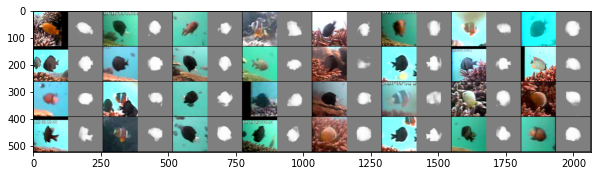

In [ ]:
#@title TRAINING
liveloss = PlotLosses()
hist = {'loss': 0, 'jaccard': 0 }
best_jaccard = 0
for epoch in range(hp.n_epochs):    
    # train
    model.train()
    running_loss = 0.0
    running_jaccard = 0.0
    print('Starting epoch {}/{}'.format(epoch+1, hp.n_epochs))
    for batch_idx, (images, masks, _) in enumerate(train_loader):
        images = Variable(images.cuda())
        masks = Variable(masks.cuda())
        
        optimizer.zero_grad()
        outputs = model(images)
        predicted = outputs.round()
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()
        
        jac = jaccard(outputs.round(), masks)
        running_jaccard += jac.item()
        running_loss += loss.item() 
        if batch_idx % hp.sample_interval == 0:
            print('    ', end='')
            print('batch {:>3}/{:>3} loss: {:.4f}, jaccard {:.4f}\r'\
                  .format(batch_idx+1, len(train_loader),
                          loss.item(), jac.item()))       
            
    # evalute
    model.eval()
    train_loss = running_loss / len(train_loader)
    train_jaccard = running_jaccard / len(train_loader) 
    hist['loss']=train_loss
    hist['jaccard']=train_jaccard    
    liveloss.update(hist)
    liveloss.send()
    visualise_output(sample_images(batch_idx),10,10)
    
    

        
    

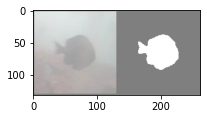

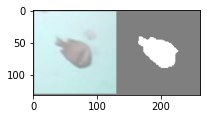

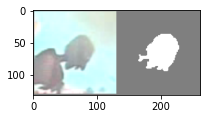

In [ ]:
dataiter = iter(val_loader)
(images, masks, _) = dataiter.next()
img_sample, mask_sample = zip(*random.sample(list(zip(images, masks)), no_images))
for i in range(len(img_sample)):  
  imshow(make_grid([img_sample[i], mask_sample[i].repeat(3, 1, 1)]), size=pic_size)